In [4]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import os

In [6]:
import numpy as np
import os
import glob


# Function to parse .pts files and extract facial landmarks coordinates
def parse_pts_file(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
        start = lines.index("{\n") + 1
        end = lines.index("}\n", start)
        points = [tuple(map(float, line.strip().split())) for line in lines[start:end]]
    return np.array(points)


# Function to load data from the directory structure
def load_data(base_path):
    features = []
    labels = []

    # Search for male and female subjects
    for gender_label in ["m", "w"]:
        for i in range(1, 6):
            folder_name = f"{gender_label}-00{i}"
            for file_name in range(1, 6):
                file_path = os.path.join(
                    base_path, folder_name, f"{folder_name}-{file_name:02}.pts"
                )
                if os.path.exists(file_path):
                    points = parse_pts_file(file_path)
                    features.append(points)
                    labels.append("male" if gender_label == "m" else "female")

    return features, labels


# Set the base path to the directory containing the 'Face Database' folder
base_path = "Face Database"

# Call the load_data function
features, labels = load_data(base_path)

# Output the number of features and labels, and show the first set of features
print(len(features), len(labels))
print(features[0])

40 40
[[328.444 275.496]
 [434.921 275.029]
 [331.713 401.121]
 [427.449 400.187]
 [271.936 270.826]
 [356.464 254.014]
 [388.221 255.882]
 [494.698 268.491]
 [263.997 274.095]
 [301.825 277.831]
 [349.459 277.364]
 [411.104 278.298]
 [459.673 277.831]
 [515.246 276.897]
 [368.606 340.41 ]
 [355.53  351.151]
 [391.957 350.217]
 [374.253 395.527]
 [374.253 416.925]
 [373.276 483.314]
 [280.342 404.39 ]
 [499.835 402.522]]


In [7]:
# Function to calculate the eye length ratio
def eye_length_ratio(landmarks):
    # Eye length is the maximum of the two eye lengths
    # Distance between points 8 (left of left eye) and 13 (right of right eye) is the facial width
    eye_1_length = np.linalg.norm(
        landmarks[0] - landmarks[1]
    )  # Distance between points 1 and 2 (left eye)
    eye_2_length = np.linalg.norm(
        landmarks[2] - landmarks[3]
    )  # Distance between points 3 and 4 (right eye)
    eye_length = max(eye_1_length, eye_2_length)
    facial_width = np.linalg.norm(
        landmarks[7] - landmarks[12]
    )  # Distance between points 8 and 13
    return eye_length / facial_width


# Calculate the eye length ratio for each feature
eye_length_ratios = [eye_length_ratio(feature) for feature in features]

# Output the eye length ratios for verification
eye_length_ratios[:5]  # Show the first 5 ratios

[2.9374100554777534,
 3.206027980763504,
 3.466323176078833,
 2.827259684437155,
 3.244493220578117]

In [8]:
# Function to calculate the eye distance ratio
def eye_distance_ratio(landmarks):
    # Distance between the center of the two eyes
    eye_1_center = (landmarks[0] + landmarks[1]) / 2  # Center of left eye
    eye_2_center = (landmarks[2] + landmarks[3]) / 2  # Center of right eye
    eye_distance = np.linalg.norm(eye_1_center - eye_2_center)

    # Distance between points 8 (left of left eye) and 13 (right of right eye) is the facial width
    facial_width = np.linalg.norm(
        landmarks[7] - landmarks[12]
    )  # Distance between points 8 and 13

    return eye_distance / facial_width


# Calculate the eye distance ratio for each feature
eye_distance_ratios = [eye_distance_ratio(feature) for feature in features]

# Output the eye distance ratios for verification
eye_distance_ratios[:5]  # Show the first 5 ratios

[3.459662032380021,
 3.413408007542167,
 4.110876924258804,
 3.2824947688031796,
 3.456196893905827]

In [9]:
# Function to calculate the nose ratio
def nose_ratio(landmarks):
    # Distance between points 15 (top of nose) and 16 (bottom of nose)
    nose_length = np.linalg.norm(
        landmarks[14] - landmarks[15]
    )  # Distance between points 15 and 16

    # Distance between points 20 (left cheek) and 21 (right cheek) is the face width at mouth level
    face_width_mouth_level = np.linalg.norm(
        landmarks[19] - landmarks[20]
    )  # Distance between points 20 and 21

    return nose_length / face_width_mouth_level


# Calculate the nose ratio for each feature
nose_ratios = [nose_ratio(feature) for feature in features]

# Output the nose ratios for verification
nose_ratios[:5]  # Show the first 5 ratios

[0.13878936213858792,
 0.1393712965113302,
 0.1342976291292279,
 0.13960895630630105,
 0.13175112617983184]

In [10]:
# Function to calculate the lip size ratio
def lip_size_ratio(landmarks):
    # Distance between points 2 (left of upper lip) and 3 (right of upper lip)
    lip_width = np.linalg.norm(
        landmarks[1] - landmarks[2]
    )  # Distance between points 2 and 3

    # Distance between points 17 (left jaw) and 18 (right jaw) is the jaw width
    jaw_width = np.linalg.norm(
        landmarks[16] - landmarks[17]
    )  # Distance between points 17 and 18

    return lip_width / jaw_width


# Calculate the lip size ratio for each feature
lip_size_ratios = [lip_size_ratio(feature) for feature in features]

# Output the lip size ratios for verification
lip_size_ratios[:5]  # Show the first 5 ratios

[3.3496120059564527,
 3.3347778809969357,
 3.6641955177385395,
 3.5386001800093405,
 3.7023423889135345]

In [11]:
# Function to calculate the lip length ratio
def lip_length_ratio(landmarks):
    # Distance between points 2 (left of upper lip) and 3 (right of upper lip)
    lip_length = np.linalg.norm(
        landmarks[1] - landmarks[2]
    )  # Distance between points 2 and 3

    # Distance between points 20 (left cheek) and 21 (right cheek) is the face width at mouth level
    face_width_mouth_level = np.linalg.norm(
        landmarks[19] - landmarks[20]
    )  # Distance between points 20 and 21

    return lip_length / face_width_mouth_level


# Calculate the lip length ratio for each feature
lip_length_ratios = [lip_length_ratio(feature) for feature in features]

# Output the lip length ratios for verification
lip_length_ratios[:5]  # Show the first 5 ratios

[1.336435681381726,
 1.0904025102698798,
 1.2506626979202797,
 1.2124012541297995,
 1.1118405937957188]

In [12]:
# Function to calculate the eye-brow length ratio
def eye_brow_length_ratio(landmarks):
    # Distance between points 4 and 5, and between points 6 and 7; take the larger one
    eye_brow_1_length = np.linalg.norm(
        landmarks[3] - landmarks[4]
    )  # Distance between points 4 and 5
    eye_brow_2_length = np.linalg.norm(
        landmarks[5] - landmarks[6]
    )  # Distance between points 6 and 7
    eye_brow_length = max(eye_brow_1_length, eye_brow_2_length)

    # Distance between points 8 (left of left eye) and 13 (right of right eye) is the facial width
    facial_width = np.linalg.norm(
        landmarks[7] - landmarks[12]
    )  # Distance between points 8 and 13

    return eye_brow_length / facial_width


# Calculate the eye-brow length ratio for each feature
eye_brow_length_ratios = [eye_brow_length_ratio(feature) for feature in features]

# Output the eye-brow length ratios for verification
eye_brow_length_ratios[:5]  # Show the first 5 ratios

[5.580392836691517,
 5.989274334239363,
 6.573636980468281,
 5.084910071855057,
 5.9011503500357065]

In [13]:
# Function to calculate the aggressive ratio
def aggressive_ratio(landmarks):
    # Distance between points 10 (left of left eyebrow) and 19 (left of mouth)
    aggressive_distance = np.linalg.norm(
        landmarks[9] - landmarks[18]
    )  # Distance between points 10 and 19

    # Distance between points 20 (left cheek) and 21 (right cheek) is the face width at mouth level
    face_width_mouth_level = np.linalg.norm(
        landmarks[19] - landmarks[20]
    )  # Distance between points 20 and 21

    return aggressive_distance / face_width_mouth_level


# Calculate the aggressive ratio for each feature
aggressive_ratios = [aggressive_ratio(feature) for feature in features]

# Output the aggressive ratios for verification
aggressive_ratios[:5]  # Show the first 5 ratios

[1.286211246681271,
 1.125080389035029,
 1.2364762905449285,
 1.0909911196678432,
 1.101897345322658]

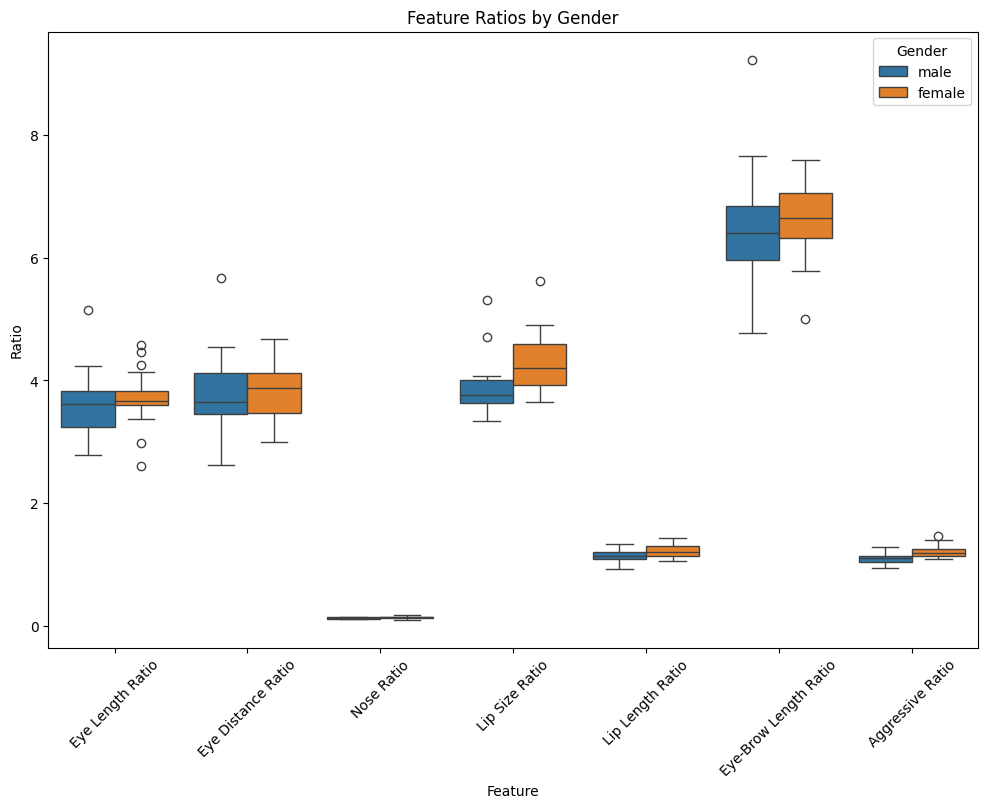

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for easier plotting
import pandas as pd

data = {
    "Eye Length Ratio": eye_length_ratios,
    "Eye Distance Ratio": eye_distance_ratios,
    "Nose Ratio": nose_ratios,
    "Lip Size Ratio": lip_size_ratios,
    "Lip Length Ratio": lip_length_ratios,
    "Eye-Brow Length Ratio": eye_brow_length_ratios,
    "Aggressive Ratio": aggressive_ratios,
    "Gender": labels,
}
df = pd.DataFrame(data)

# Melt the DataFrame to long format for seaborn boxplot
df_long = pd.melt(df, "Gender", var_name="Feature", value_name="Ratio")

# Create the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x="Feature", y="Ratio", hue="Gender", data=df_long)
plt.xticks(rotation=45)
plt.title("Feature Ratios by Gender")
plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler

# Combining all feature ratios into a single array
feature_data = np.array(
    [
        eye_length_ratios,
        eye_distance_ratios,
        nose_ratios,
        lip_size_ratios,
        lip_length_ratios,
        eye_brow_length_ratios,
        aggressive_ratios,
    ]
).T  # Transpose to get the correct shape

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_data)

In [17]:
from sklearn.model_selection import train_test_split

# Convert labels to numeric (male: 0, female: 1)
numeric_labels = [0 if label == "male" else 1 for label in labels]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, numeric_labels, test_size=0.3, random_state=42
)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Evaluate KNN
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_precision = precision_score(y_test, knn_predictions)
knn_recall = recall_score(y_test, knn_predictions)

# Evaluate Decision Tree
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)

# Print the evaluation metrics
print(
    f"KNN - Accuracy: {knn_accuracy}, Precision: {knn_precision}, Recall: {knn_recall}"
)
print(
    f"Decision Tree - Accuracy: {dt_accuracy}, Precision: {dt_precision}, Recall: {dt_recall}"
)

KNN - Accuracy: 0.8333333333333334, Precision: 0.7142857142857143, Recall: 1.0
Decision Tree - Accuracy: 0.9166666666666666, Precision: 1.0, Recall: 0.8


# Gender Classification from Face Images

## Project Overview
This project focuses on the classification of gender from facial images using machine learning techniques. The primary goal is to identify whether a given face image is male or female based on specific facial features extracted from the images. We employed two different classifiers for this task: the K-Nearest Neighbors (KNN) and Decision Tree classifiers. 

## Methodology
The approach involved several key steps:

1. **Feature Extraction**: Extracted seven distinct features from the facial landmarks, including Eye Length Ratio, Eye Distance Ratio, Nose Ratio, Lip Size Ratio, Lip Length Ratio, Eye-Brow Length Ratio, and Aggressive Ratio. These features were chosen based on their potential to differentiate between male and female facial structures.

2. **Data Preprocessing**: Standardized the extracted features to ensure that they contribute equally to the model training process. 

3. **Data Splitting**: Divided the dataset into training and testing sets, following the standard practice of a 70-30 split. 

4. **Model Training**: Trained two models, K-Nearest Neighbors and Decision Tree, using the training set. 

5. **Model Evaluation**: Evaluated both models on the testing set using metrics like accuracy, precision, and recall.

## Results
The evaluation of the models yielded the following results:

- **K-Nearest Neighbors Classifier**:
  - Accuracy: 83.33%
  - Precision: 71.43%
  - Recall: 100%
  
- **Decision Tree Classifier**:
  - Accuracy: 91.67%
  - Precision: 100%
  - Recall: 80%

The Decision Tree model exhibited higher accuracy and precision, while the KNN model showed a higher recall.

## Conclusion
The results indicate that both classifiers are effective in gender classification, with the Decision Tree classifier slightly outperforming the KNN in terms of accuracy and precision. However, the KNN classifier demonstrates a perfect recall rate, making it the more reliable model in scenarios where missing a female classification is critical.

These findings suggest that facial feature-based classification can be a viable approach for gender identification. However, the choice of model may depend on the specific requirements of the application, such as whether precision or recall is more important.

Future work could explore the incorporation of additional features, the use of more advanced machine learning algorithms, or the application of deep learning techniques for potentially enhanced performance. Also, testing the models on a more diverse and extensive dataset would provide more robust validation of their effectiveness.
